# Portfolio Data Download

This notebook downloads daily stock price data from Yahoo Finance for tickers listed in stocks_list.csv

Data is saved to the `/data` folder

In [13]:
import pandas as pd
import numpy as np
import edhec_risk_ph as erk
import os
%load_ext autoreload
%autoreload 2

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Load Stock Tickers from CSV

In [14]:
# Read the stocks list
stocks_df = pd.read_csv('stocks_list.csv')
tickers = stocks_df['ticker'].dropna().unique().tolist()

print(f"Found {len(tickers)} unique tickers:")
print(tickers)

Found 30 unique tickers:
['SCHD', 'VOO', 'VTI', 'SPY', 'IVV', 'GOOGL', 'AAPL', 'MSFT', 'AMZN', 'VIG', 'NFLX', 'NVDA', 'IBM', 'BMY', 'FTNT', 'PSTG', 'ASML', 'AVNT', 'PWR', 'TTD', 'COST', 'AES', 'SGMO', 'NVO', 'VIGI', 'VYM', 'SAM', 'SCHY', 'VMBS', 'VEU']


## Step 2: Check for Existing Data and Download Incrementally

This cell checks if existing data files are present and downloads only new data if available

In [15]:
# Check for existing data files
prices_filename = 'data/portfolio_prices_10y.csv'
returns_filename = 'data/portfolio_returns_10y.csv'

existing_prices = None
existing_returns = None
start_date = None

if os.path.exists(prices_filename):
    print(f"✓ Found existing prices file: {prices_filename}")
    existing_prices = pd.read_csv(prices_filename, index_col=0, parse_dates=True)
    existing_prices.columns.name = 'Ticker'
    
    latest_date = existing_prices.index[-1]
    print(f"  Latest date in file: {latest_date.date()}")
    
    # Calculate days since last update
    days_since = (pd.Timestamp.now() - latest_date).days
    print(f"  Days since last update: {days_since}")
    
    if days_since <= 1:
        print("  → Data is current (updated within last day)")
    else:
        print(f"  → Will download incremental data from {latest_date.date()}")
    
    start_date = latest_date
else:
    print(f"✗ No existing prices file found")
    print(f"  → Will download full 10 years of data")

if os.path.exists(returns_filename):
    print(f"✓ Found existing returns file: {returns_filename}")
    existing_returns = pd.read_csv(returns_filename, index_col=0, parse_dates=True)
    existing_returns.columns.name = 'Ticker'

# Get existing tickers if files exist
existing_tickers = set(existing_prices.columns.tolist()) if existing_prices is not None else set()
new_tickers = set(tickers) - existing_tickers
removed_tickers = existing_tickers - set(tickers)

if new_tickers:
    print(f"\n✓ New tickers to add: {sorted(new_tickers)}")
if removed_tickers:
    print(f"⚠️  Tickers removed from stocks_list.csv: {sorted(removed_tickers)}")

print("\n" + "="*60)

✓ Found existing prices file: data/portfolio_prices_10y.csv
  Latest date in file: 2026-02-04
  Days since last update: 0
  → Data is current (updated within last day)
✓ Found existing returns file: data/portfolio_returns_10y.csv



## Step 3: Download New Data

Download full 10 years if no existing data, or incremental data if updating

In [16]:
# Download data
if existing_prices is not None and start_date is not None:
    days_since = (pd.Timestamp.now() - start_date).days
    
    if days_since <= 1:
        print("Data is already current. Skipping download.")
        print("If you want to force a fresh download, delete the CSV files in /data folder.\n")
        # Use existing prices directly
        close_prices = existing_prices
    else:
        # Download incremental data for all tickers (including new ones)
        print(f"Downloading incremental data from {start_date.date()} to today...")
        print(f"Tickers: {len(tickers)} total ({len(new_tickers)} new)")
        
        # Download full 10y data
        prices_data = erk.get_from_yahoo(tickers, period='10y')
        
        # Filter to only dates after the existing data
        new_data = prices_data[prices_data.index > start_date]
        
        if len(new_data) == 0:
            print("\n✓ No new data available. Using existing data.")
            close_prices = existing_prices
        else:
            print(f"\n✓ Downloaded {len(new_data)} new rows")
            
            # Extract close prices from new data
            new_close_prices = new_data['Close']
            
            # Merge with existing data
            for ticker in new_tickers:
                if ticker not in existing_prices.columns:
                    existing_prices[ticker] = np.nan
            
            existing_prices = existing_prices[[t for t in existing_prices.columns if t in tickers]]
            
            for ticker in tickers:
                if ticker not in new_close_prices.columns:
                    new_close_prices[ticker] = np.nan
            
            # Concatenate old and new data
            close_prices = pd.concat([existing_prices, new_close_prices])
            close_prices = close_prices[~close_prices.index.duplicated(keep='last')]
            close_prices = close_prices.sort_index()
            
            print(f"✓ Merged data: {len(close_prices)} total rows")
            print(f"  Date range: {close_prices.index[0].date()} to {close_prices.index[-1].date()}")
else:
    # Download full 10 years of data
    print("Downloading full 10 years of data for all tickers...")
    prices_data = erk.get_from_yahoo(tickers, period='10y')
    
    print(f"\n✓ Downloaded {len(prices_data)} rows")
    print(f"  Date range: {prices_data.index[0].date()} to {prices_data.index[-1].date()}")
    
    # Extract close prices immediately
    close_prices = prices_data['Close'].copy()
    
    print(f"✓ Extracted {len(close_prices)} close price rows")
    print(f"  Close prices date range: {close_prices.index[0].date()} to {close_prices.index[-1].date()}")

# Display summary
print(f"\nFinal close_prices shape: {close_prices.shape}")
close_prices.head()

Data is already current. Skipping download.
If you want to force a fresh download, delete the CSV files in /data folder.


Final close_prices shape: (2514, 30)


Ticker,AAPL,AES,AMZN,ASML,AVNT,BMY,COST,FTNT,GOOGL,IBM,...,SGMO,SPY,TTD,VEU,VIG,VIGI,VMBS,VOO,VTI,VYM
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-05,21.313618,6.709842,25.106501,79.910393,19.722773,42.355865,120.994202,5.022,34.924122,80.387794,...,5.66,159.294830,NaN,29.464651,61.513542,NaN,40.823349,145.440613,80.803917,46.883419
2016-02-08,21.538046,6.496504,24.405001,78.101624,19.379835,43.130104,123.540344,4.846,34.943974,80.204605,...,5.57,157.150589,NaN,28.925848,61.084190,NaN,40.846325,143.440155,79.548523,46.662792
2016-02-09,21.533506,6.544678,24.103500,76.844551,19.882277,43.343193,124.313385,4.768,34.788151,78.366585,...,5.46,157.159027,NaN,28.593710,61.265823,NaN,40.815720,143.482422,79.446739,46.611309
2016-02-10,21.370296,6.558444,24.524000,73.923431,19.922153,43.385815,124.743080,4.782,35.077457,75.915855,...,4.92,157.023438,NaN,28.578945,61.075943,NaN,40.876919,143.389587,79.497635,46.412746
2016-02-11,21.241074,6.193703,25.191000,73.986710,20.057734,42.277725,123.563477,4.766,35.053150,74.437828,...,4.91,154.980865,NaN,28.180380,60.275040,NaN,40.930454,141.549454,78.513657,45.839119


## Step 4: Verify Close Prices Data

In [17]:
# Verify close prices are ready
print(f"Close prices shape: {close_prices.shape}")
print(f"Date range: {close_prices.index[0].date()} to {close_prices.index[-1].date()}")
print(f"Number of trading days: {len(close_prices)}")
print(f"\nMissing values per ticker:")
print(close_prices.isnull().sum().sort_values(ascending=False).head(10))

close_prices.head(10)

Close prices shape: (2514, 30)
Date range: 2016-02-05 to 2026-02-04
Number of trading days: 2514

Missing values per ticker:
Ticker
SCHY    1316
TTD      158
VIGI      17
AAPL       0
AES        0
VTI        0
VOO        0
VMBS       0
VIG        0
VEU        0
dtype: int64


Ticker,AAPL,AES,AMZN,ASML,AVNT,BMY,COST,FTNT,GOOGL,IBM,...,SGMO,SPY,TTD,VEU,VIG,VIGI,VMBS,VOO,VTI,VYM
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-05,21.313618,6.709842,25.106501,79.910393,19.722773,42.355865,120.994202,5.022,34.924122,80.387794,...,5.66,159.294830,NaN,29.464651,61.513542,NaN,40.823349,145.440613,80.803917,46.883419
2016-02-08,21.538046,6.496504,24.405001,78.101624,19.379835,43.130104,123.540344,4.846,34.943974,80.204605,...,5.57,157.150589,NaN,28.925848,61.084190,NaN,40.846325,143.440155,79.548523,46.662792
2016-02-09,21.533506,6.544678,24.103500,76.844551,19.882277,43.343193,124.313385,4.768,34.788151,78.366585,...,5.46,157.159027,NaN,28.593710,61.265823,NaN,40.815720,143.482422,79.446739,46.611309
2016-02-10,21.370296,6.558444,24.524000,73.923431,19.922153,43.385815,124.743080,4.782,35.077457,75.915855,...,4.92,157.023438,NaN,28.578945,61.075943,NaN,40.876919,143.389587,79.497635,46.412746
2016-02-11,21.241074,6.193703,25.191000,73.986710,20.057734,42.277725,123.563477,4.766,35.053150,74.437828,...,4.91,154.980865,NaN,28.180380,60.275040,NaN,40.930454,141.549454,78.513657,45.839119
2016-02-12,21.306818,6.310694,25.354000,74.194725,20.639925,42.760738,125.248642,4.822,35.079453,76.452751,...,4.96,158.176086,NaN,28.637997,61.373199,NaN,40.853954,144.453064,80.040512,46.743687
2016-02-16,21.907549,6.455214,26.055000,75.949219,20.695757,44.167145,125.636215,5.084,35.612919,77.526512,...,5.41,160.845886,NaN,29.235836,62.215382,NaN,40.838661,146.875534,81.499496,47.420292
2016-02-17,22.243053,6.620381,26.705000,78.029243,20.919062,45.403099,127.152901,5.236,36.324047,79.648766,...,5.63,163.473206,NaN,29.789417,62.999790,NaN,40.853954,149.281128,82.848206,48.015980
2016-02-18,21.821415,6.675436,26.250000,77.703690,20.935011,44.976913,125.248642,5.118,35.606464,83.659637,...,5.32,162.803680,NaN,29.656561,62.975018,NaN,40.915146,148.648056,82.517395,48.023350


## Step 5: Calculate Daily Returns

Using the `calculate_daily_returns()` function from edhec_risk_ph

In [18]:
# Calculate daily returns from close prices
daily_returns = close_prices.pct_change()

# Drop only the first row (which will be all NaN from pct_change)
# Do NOT use dropna() because it will remove rows where any ticker has NaN
# Some tickers (like SCHY, TTD) don't have full 10-year history
daily_returns = daily_returns.iloc[1:]  # Skip first row which is all NaN from pct_change

daily_returns.columns.name = 'Ticker'

print(f"Daily returns shape: {daily_returns.shape}")
print(f"Date range: {daily_returns.index[0].date()} to {daily_returns.index[-1].date()}")
print(f"\nMissing values per ticker (from stocks with shorter history):")
missing_counts = daily_returns.isnull().sum()
print(missing_counts[missing_counts > 0].sort_values(ascending=False))
print(f"\nFirst few returns:")
daily_returns.head(10)

Daily returns shape: (2513, 30)
Date range: 2016-02-08 to 2026-02-04

Missing values per ticker (from stocks with shorter history):
Ticker
SCHY    1316
TTD      158
VIGI      17
dtype: int64

First few returns:


Ticker,AAPL,AES,AMZN,ASML,AVNT,BMY,COST,FTNT,GOOGL,IBM,...,SGMO,SPY,TTD,VEU,VIG,VIGI,VMBS,VOO,VTI,VYM
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-08,0.010530,-0.031795,-0.027941,-0.022635,-0.017388,0.018279,0.021044,-0.035046,0.000568,-0.002279,...,-0.015901,-0.013461,NaN,-0.018286,-0.006980,NaN,0.000563,-0.013754,-0.015536,-0.004706
2016-02-09,-0.000211,0.007415,-0.012354,-0.016095,0.025926,0.004941,0.006257,-0.016096,-0.004459,-0.022917,...,-0.019749,0.000054,NaN,-0.011482,0.002973,NaN,-0.000749,0.000295,-0.001280,-0.001103
2016-02-10,-0.007579,0.002104,0.017446,-0.038013,0.002006,0.000983,0.003457,0.002936,0.008316,-0.031273,...,-0.098901,-0.000863,NaN,-0.000516,-0.003099,NaN,0.001499,-0.000647,0.000641,-0.004260
2016-02-11,-0.006047,-0.055614,0.027198,0.000856,0.006805,-0.025540,-0.009456,-0.003346,-0.000693,-0.019469,...,-0.002033,-0.013008,NaN,-0.013946,-0.013113,NaN,0.001310,-0.012833,-0.012377,-0.012359
2016-02-12,0.003095,0.018889,0.006471,0.002812,0.029026,0.011425,0.013638,0.011750,0.000750,0.027069,...,0.010183,0.020617,NaN,0.016239,0.018219,NaN,-0.001869,0.020513,0.019447,0.019734
2016-02-16,0.028194,0.022901,0.027649,0.023647,0.002705,0.032890,0.003094,0.054334,0.015207,0.014045,...,0.090726,0.016879,NaN,0.020876,0.013722,NaN,-0.000374,0.016770,0.018228,0.014475
2016-02-17,0.015315,0.025587,0.024947,0.027387,0.010790,0.027984,0.012072,0.029898,0.019968,0.027375,...,0.040665,0.016334,NaN,0.018935,0.012608,NaN,0.000374,0.016378,0.016549,0.012562
2016-02-18,-0.018956,0.008316,-0.017038,-0.004172,0.000762,-0.009387,-0.014976,-0.022536,-0.019755,0.050357,...,-0.055062,-0.004096,NaN,-0.004460,-0.000393,NaN,0.001498,-0.004241,-0.003993,0.000153
2016-02-19,-0.002286,-0.029897,0.018857,0.024325,0.001905,0.007580,0.000336,0.019539,0.006411,0.004757,...,0.000000,-0.000469,NaN,-0.002737,-0.000132,NaN,-0.001122,-0.000227,0.000206,-0.002451


## Step 6: Save Price and Returns Data to CSV

## Step 7: Quick Data Quality Check

In [19]:
# Check for any tickers with excessive missing data
print("=" * 60)
print("MISSING DATA ANALYSIS")
print("=" * 60)

missing_pct = (close_prices.isnull().sum() / len(close_prices)) * 100
print("\nPercentage of missing data per ticker:")
print(missing_pct.sort_values(ascending=False))

# Show tickers with more than 10% missing data
problematic = missing_pct[missing_pct > 10]
if len(problematic) > 0:
    print(f"\n⚠️  Warning: {len(problematic)} tickers have >10% missing data:")
    print(problematic)
else:
    print("\n✓ All tickers have <10% missing data")

# Show basic statistics for returns
print("\n" + "=" * 60)
print("RETURNS STATISTICS")
print("=" * 60)
print("\nDaily returns summary:")
print(daily_returns.describe())

MISSING DATA ANALYSIS

Percentage of missing data per ticker:
Ticker
SCHY     52.346858
TTD       6.284805
VIGI      0.676213
AAPL      0.000000
AES       0.000000
VTI       0.000000
VOO       0.000000
VMBS      0.000000
VIG       0.000000
VEU       0.000000
SPY       0.000000
SGMO      0.000000
SCHD      0.000000
SAM       0.000000
PWR       0.000000
PSTG      0.000000
NVO       0.000000
NVDA      0.000000
NFLX      0.000000
MSFT      0.000000
IVV       0.000000
IBM       0.000000
GOOGL     0.000000
FTNT      0.000000
COST      0.000000
BMY       0.000000
AVNT      0.000000
ASML      0.000000
AMZN      0.000000
VYM       0.000000
dtype: float64

⚠️  Warning: 1 tickers have >10% missing data:
Ticker
SCHY    52.346858
dtype: float64

RETURNS STATISTICS

Daily returns summary:
Ticker         AAPL          AES         AMZN         ASML         AVNT  \
count   2513.000000  2513.000000  2513.000000  2513.000000  2513.000000   
mean       0.001185     0.000596     0.001095     0.001406     0

In [20]:
# Save close prices to CSV in data folder
prices_filename = 'data/portfolio_prices_10y.csv'
close_prices.to_csv(prices_filename)
print(f"Prices saved to {prices_filename}")
print(f"  → {len(close_prices)} rows and {len(close_prices.columns)} ticker columns")

# Save daily returns to CSV in data folder
returns_filename = 'data/portfolio_returns_10y.csv'
daily_returns.to_csv(returns_filename)
print(f"\nReturns saved to {returns_filename}")
print(f"  → {len(daily_returns)} rows and {len(daily_returns.columns)} ticker columns")

Prices saved to data/portfolio_prices_10y.csv
  → 2514 rows and 30 ticker columns

Returns saved to data/portfolio_returns_10y.csv
  → 2513 rows and 30 ticker columns


## Step 8: Plot Cumulative Returns for Selected Stocks

Select stocks to compare and visualize their cumulative returns over time

In [21]:
import matplotlib.pyplot as plt

# User input: Select stocks to plot (edit this list)
# Available tickers: AAPL, AES, AMZN, ASML, AVNT, BMY, COST, FTNT, GOOGL, IBM, 
#                    IVV, MSFT, NFLX, NVDA, NVO, PSTG, PWR, SAM, SCHD, SCHY,
#                    SGMO, SPY, TTD, VEU, VIG, VIGI, VMBS, VOO, VTI, VYM

selected_stocks = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'SPY']  # EDIT THIS LIST

# Validate that all selected stocks are available
available_tickers = daily_returns.columns.tolist()
invalid_stocks = [s for s in selected_stocks if s not in available_tickers]

if invalid_stocks:
    print(f"⚠️  Warning: These tickers are not available: {invalid_stocks}")
    print(f"Available tickers: {available_tickers}")
    selected_stocks = [s for s in selected_stocks if s in available_tickers]

print(f"Plotting cumulative returns for: {selected_stocks}")

Plotting cumulative returns for: ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'SPY']


In [22]:
# Calculate cumulative returns for selected stocks
# Cumulative return = (1 + daily_return).cumprod() - 1
selected_returns = daily_returns[selected_stocks]
cumulative_returns = (1 + selected_returns).cumprod() - 1

# Convert to percentage for easier reading
cumulative_returns_pct = cumulative_returns * 100

print("Cumulative returns (%):")
print(cumulative_returns_pct.tail(10))

Cumulative returns (%):
Ticker             AAPL        MSFT       GOOGL          NVDA         SPY
Date                                                                     
2026-01-22  1065.217513  927.171148  846.451882  28570.887595  332.518732
2026-01-23  1063.762983  960.891061  838.978492  29009.854625  332.675674
2026-01-26  1098.341864  970.749724  854.240199  28823.720789  334.872857
2026-01-27  1111.760446  994.201092  857.933858  29141.700708  336.605500
2026-01-28  1103.174449  996.591810  862.114412  29607.036482  336.561552
2026-01-29  1111.807410  887.007754  868.528289  29760.595773  335.695230
2026-01-30  1117.437671  879.699135  867.812452  29546.542926  334.395749
2026-02-02  1166.842699  863.943410  884.104923  28690.324439  336.555268
2026-02-03  1164.356031  836.257094  872.708757  27872.883933  332.864035
2026-02-04  1197.245705  843.042086  853.610258  26918.946543  330.767277


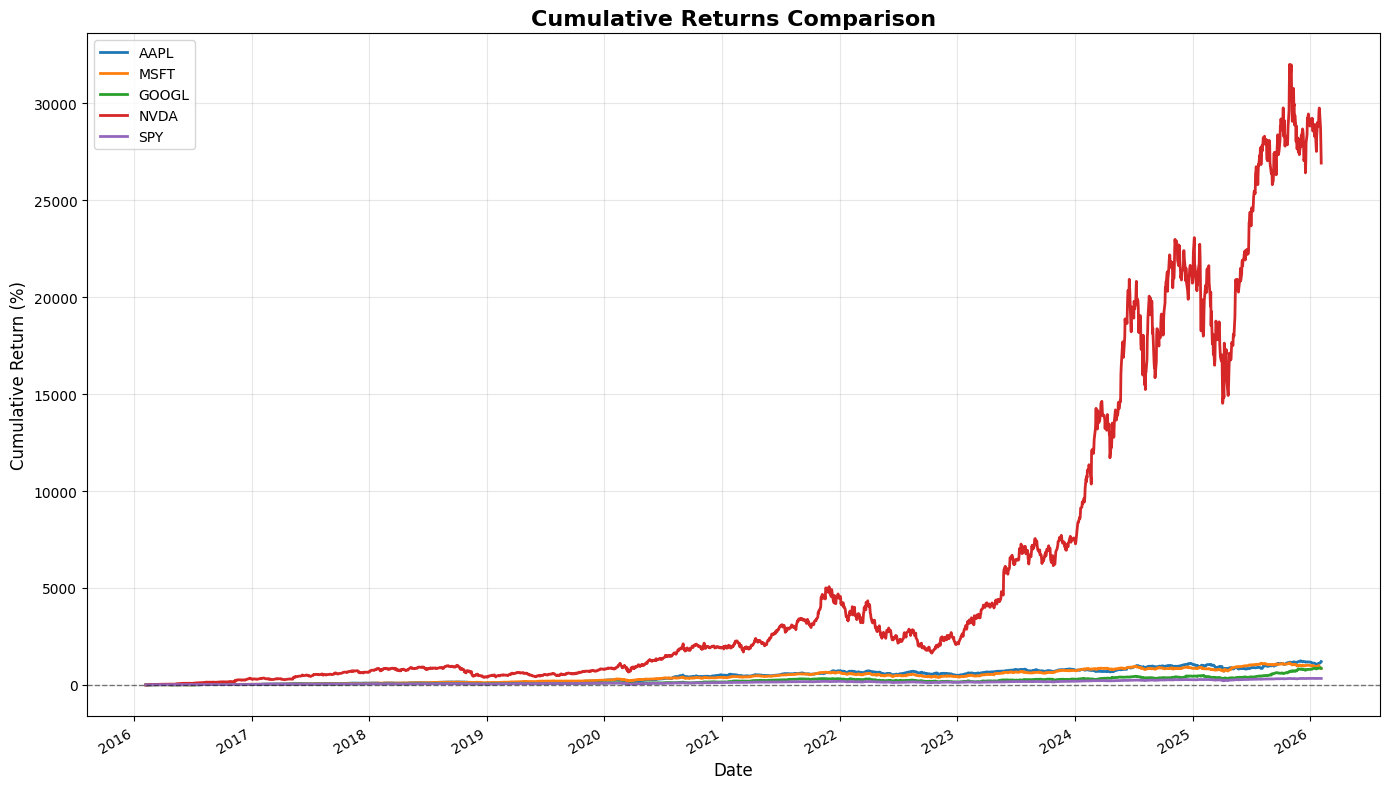


FINAL CUMULATIVE RETURNS
NVDA  : 26918.95%
AAPL  :  1197.25%
GOOGL :   853.61%
MSFT  :   843.04%
SPY   :   330.77%


In [23]:
# Plot cumulative returns over time
plt.figure(figsize=(14, 8))

for ticker in selected_stocks:
    plt.plot(cumulative_returns_pct.index, 
             cumulative_returns_pct[ticker], 
             label=ticker, 
             linewidth=2)

plt.title('Cumulative Returns Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Print final cumulative returns
print("\n" + "=" * 60)
print("FINAL CUMULATIVE RETURNS")
print("=" * 60)
final_returns = cumulative_returns_pct.iloc[-1].sort_values(ascending=False)
for ticker, ret in final_returns.items():
    print(f"{ticker:6s}: {ret:8.2f}%")